<a href="https://colab.research.google.com/github/mkri/master/blob/master/smart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.5MB/s 
     |████████████████████████████████| 194kB 10.0MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 1.1MB 8.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
Mounted at /content/gdrive


In [38]:
from google.colab import drive
drive.flush_and_unmount()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [27]:
key = os.environ.get('AZURE_SEARCH_KEY', '0f9faf6d33b74f0092f5670f1c9d2e7c')

In [43]:
!pip install bing-image-downloader
from bing_image_downloader import downloader

In [40]:
results = search_images_bing(key, 'drupes fruits')
images = results.attrgot('content_url')
len(images)

150

In [44]:
downloader.download("Apple fruit", limit=150, output_dir='fruits', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("Grabe fruit", limit=150, output_dir='fruits', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("Pear fruit", limit=150, output_dir='fruits', adult_filter_off=True, force_replace=False, timeout=5)



[!!]Indexing page: 1

[%] Indexed 150 Images on Page 1.


[%] Downloading Image #1 from https://www.healthbenefitstimes.com/9/gallery/apple/Apple-fruit.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://dairyfoodblog.files.wordpress.com/2017/08/apple4.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://www.theayurveda.org/wp-content/uploads/2015/08/Apple-fruit.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://www.chhajedgarden.com/media/catalog/product/cache/1/image/9df78eab33525d08d6e5fb8d27136e95/0/4/04_apples.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://www.znaturalfoods.com/1501-thickbox_default/apple-powder-organic.jpg
[!] Issue getting: https://www.znaturalfoods.com/1501-thickbox_default/apple-powder-organic.jpg
[!] Error:: HTTP Error 404: Not Found
[%] Downloading Image #5 from http://dreamicus.com/data/apple/apple-01.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://aggie-horticulture.tamu.edu/vegetabl

In [41]:
images

(#150) [None,None,None,None,None,None,None,None,None,None...]

In [76]:
apple_types=['Apple', 'Grape', 'Pear']
path = Path('fruits')

In [77]:
files = get_image_files(path)
files

(#450) [Path('fruits/Apple/Image_108.jpg'),Path('fruits/Apple/Image_124.jpg'),Path('fruits/Apple/Image_50.jpg'),Path('fruits/Apple/Image_125.jpg'),Path('fruits/Apple/Image_62.jpg'),Path('fruits/Apple/Image_94.JPG'),Path('fruits/Apple/Image_69.jpg'),Path('fruits/Apple/Image_106.jpg'),Path('fruits/Apple/Image_79.jpg'),Path('fruits/Apple/Image_36.jpg')...]

In [78]:
corrupt = verify_images(files)
corrupt

(#0) []

In [80]:
fruits = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=41),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [81]:
dls = fruits.dataloaders(path)

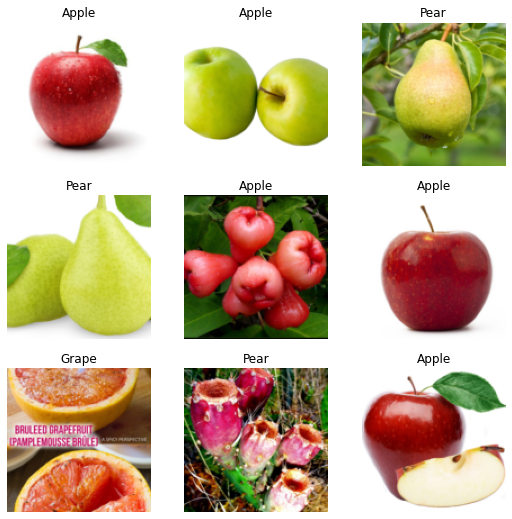

In [82]:
dls.valid.show_batch()

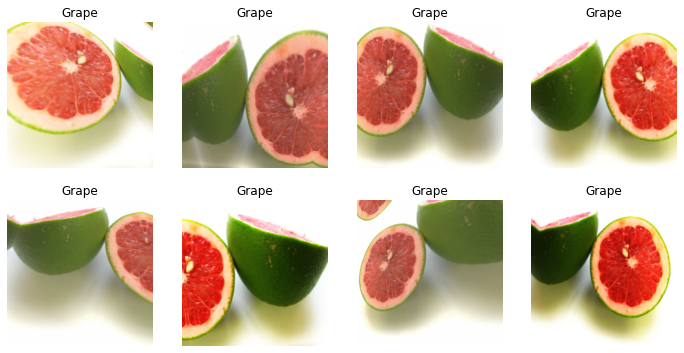

In [83]:
fruit = fruits.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [84]:
model = cnn_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.749034,0.851214,0.277778,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.636111,0.417376,0.133333,00:20
1,0.538284,0.383334,0.100000,00:19
2,0.440634,0.427062,0.111111,00:20
3,0.415370,0.417955,0.111111,00:20


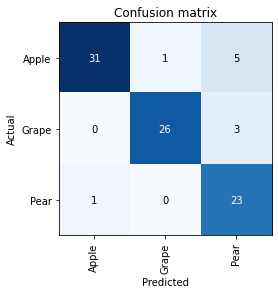

In [85]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

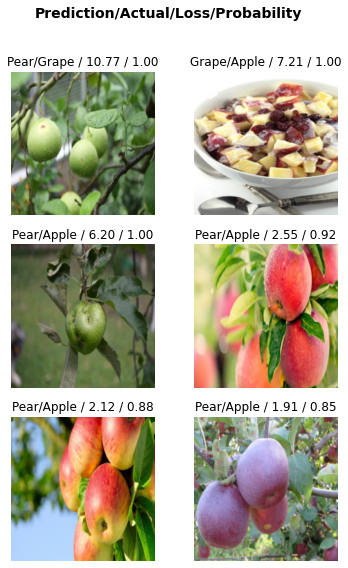

In [86]:
interp.plot_top_losses(6, nrows=3)

In [87]:
model.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [88]:
model_inf = load_learner(path/'export.pkl')

In [89]:
model_inf.predict('fruits/Apple/Image_10.jpg')

('Apple', tensor(0), tensor([9.9952e-01, 4.2623e-05, 4.3247e-04]))

In [90]:
model_inf.dls.vocab

['Apple', 'Grape', 'Pear']

In [95]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='classify')
out_pl = widgets.Output()
lbl =  widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = model_inf.predict(img)
    lbl.value = f' Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select fruit'), btn_upload, btn_run, out_pl, lbl])